# Objective Function - Stock Portfolio Optimisation

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # suppress warnings

## S&P500 Stock Prices

In [2]:
#Importing and formatting the df
stocks = pd.read_csv('adjprice.csv')
stocks['Date'] = pd.to_datetime(stocks['Date'], format='%Y%m%d')
stocks.columns = stocks.columns.str.replace(' US Equity', '')

### Function

In [16]:
def optimal_portfolio(stocksdf, NSTOCKS = 10, iterations = 1000, NSAMP = 10000, money = 10000, StartDate = "2017/01/01", 
                      EndDate = "2019/07/31", TrainEndDate = "2017/12/31", TestStartDate = "2018/01/01"):
    
    stocks_short = stocksdf[(stocksdf["Date"] >= StartDate) & (stocksdf["Date"] <= EndDate)]
    stocks_short.dropna(axis=1,inplace=True)
    stocks_short = stocks_short[(stocks_short["Date"] >= StartDate) & (stocks_short["Date"] <= TrainEndDate)]
    max_rr = 0 #set max return/risk to 0, will be used for the loop
    
    for j in range(iterations):
        stocks_return = stocks_short.iloc[-1,1:]/stocks_short.iloc[0,1:]-1 # last/first-1
        # drop all the stocks with negative return and take a random sample of the remainder
        stocks_return = stocks_return[stocks_return > 0].sample(n=NSTOCKS)
        portfolio = pd.DataFrame(stocks_short['Date'],columns=['Date'])
        for col in stocks_short.columns: # go through all the columns in our original data frame
            if col in stocks_return.index: # check if this column is in the names for our random sample
                portfolio = pd.concat([portfolio,stocks_short[col]],axis=1) # if so, add the stock prices to the new dataframe
        column_list = portfolio.columns.values.tolist()
        corrs = portfolio.diff(axis=0, periods=1).corr()
        result_array = np.zeros((2, NSAMP)) # create a numpy array to store the returns and risk for each sample
        Ro = portfolio.iloc[0,1:] # store the initial stock prices
        R = portfolio.iloc[-1,1:] # store the final stock prices

        for i in range(NSAMP): # loop over all the samples
            weight = np.random.rand(NSTOCKS) # generates weights in the range [0,1] for all the stocks
            weight = weight / weight.sum()
            if(all(k <= 0.4 for k in weight)):
                Po = weight.T @ Ro # calculate the initial value of the stock portfolio
                w = weight/Po # normalize random numbers so that portfolio has an initial value of 1
                Pf = w.T @ R # calculate final value of portfolio
                risk = np.sqrt(w.T @ corrs @ w) # calculate the risk
                if (Pf-1)/risk >= max_rr: # picks out the best weight with highest return/risk
                    max_rr = (Pf-1)/risk # stores best return/risk into max_rr
                    chosen_stocks = column_list
                    weights = weight #ensures the weights all sum up to 1
                    risk_opt = risk # stores the risk
                    opt_return = (Pf-1)*100 # stores the return
            else:
                i = i-1

    stocks_short = stocksdf[(stocks["Date"] >= TestStartDate) & (stocksdf["Date"] <= EndDate)]
    stocks_short.dropna(axis=1,inplace=True)
    new_portfolio = stocks_short[chosen_stocks]
    corrs = new_portfolio.diff(axis=0, periods=1).corr() 
    Ro = new_portfolio.iloc[0,1:] # store the initial stock prices
    R = new_portfolio.iloc[-1,1:] # store the final stock prices
    Po = weights.T @ Ro
    w = weights/Po # normalize random numbers so that portfolio has an initial value of 1
    Pf = w.T @ R # calculate final value of portfolio
    P_risk = np.sqrt(w.T @ corrs @ w) # use the formula above to calculate the risk
    P_return = (Pf - 1)*100
    weights_list = weights.tolist()
    
    print(chosen_stocks[1:])
    print("")
    print(weights_list)
    weights = pd.DataFrame(weights*100)
    returns = ((R-Ro)/Ro).to_frame()
    returns = returns.reset_index()
    stock_weights = pd.merge(returns, weights, left_index=True, right_index=True)
    stock_weights = stock_weights.set_index(['index'])
    stock_weights.columns = ['return (%)', 'weight (%)']
    stock_weights = stock_weights['weight (%)']
    stock_weights = pd.DataFrame(stock_weights)    

    stock_weights.reset_index(inplace=True)
    stockweights = stock_weights
    stockweights.sort_values(by=['weight (%)'], inplace=True, ascending=False)
    
    stockweights.plot.barh(x='index', 
                       y='weight (%)', 
                       figsize=(13, 8),
                       legend=False,
                       fontsize = 14,
                       width = 0.8,
                       ylabel ='weight',
                       xlabel = '',
                       color = 'cadetblue',
                       linewidth = 1.5,
                       edgecolor = "black");

    for index, value in enumerate(stockweights['weight (%)']):
        plt.text(value, index,' ' + str(np.round(value,2)) + '%')
 
    plt.show()
    
    print('From ' +  StartDate + ' to ' + TrainEndDate + ':')
    print('Return: ' + str(np.round(opt_return,2))+'%')
    print('Risk: ' + str(np.round(risk_opt,10)))
    print('')
    print('From ' +  TestStartDate + ' to ' + EndDate + ':')
    print('Return: ' + str(np.round(P_return,2))+'%')
    print('Risk: ' + str(np.round(P_risk,10)))
    print('')
    
    overall_return = (Pf - 1) * money 
    
    print("When investing $" + str(money) + " from " + TestStartDate + ' to ' + EndDate + ':')
    if overall_return > 0:
          print("We will profit $" + str(np.round(overall_return, 2)))
    else:
          print("We will lose $" + str(np.round(overall_return, 2)))

#### Testing the function

['AMZN', 'COST', 'GOOGL', 'IPGP', 'WLTW']

[0.3872341910551155, 0.10743963136875721, 0.25903614723858187, 0.11538197172274474, 0.13090805861480084]


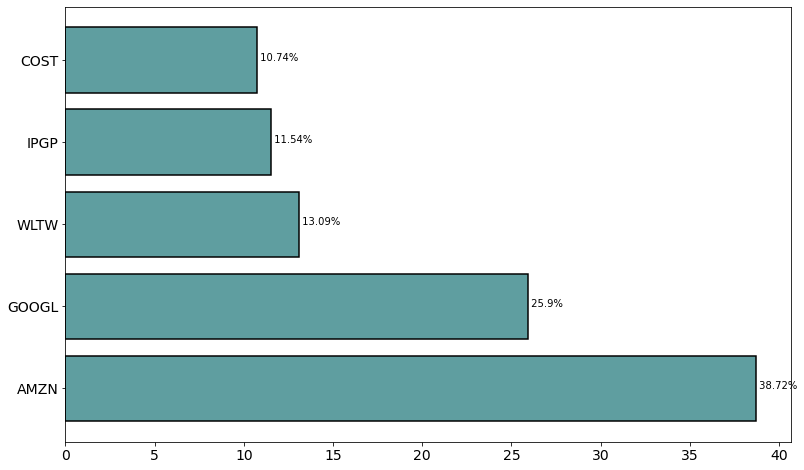

From 2017/01/01 to 2017/12/31:
Return: 46.57%
Risk: 0.0012626694

From 2018/01/01 to 2019/07/31:
Return: 42.46%
Risk: 0.0009675174

When investing $20000 from 2018/01/01 to 2019/07/31:
We will profit $8491.16


In [18]:
optimal_portfolio(stocksdf = stocks, NSTOCKS = 5, iterations = 1000, NSAMP = 1000, money = 20000)

['ADBE', 'AMG', 'AMZN', 'ANET', 'BDX', 'IAC', 'MMC', 'MS', 'WAT', 'XRX']

[0.06673362158079302, 0.1632587875848767, 0.27255550500183245, 0.05411438222548599, 0.1566759808032737, 0.08164512107719156, 0.10150265930767415, 0.02786981625988578, 0.04027513519419368, 0.03536899096479304]


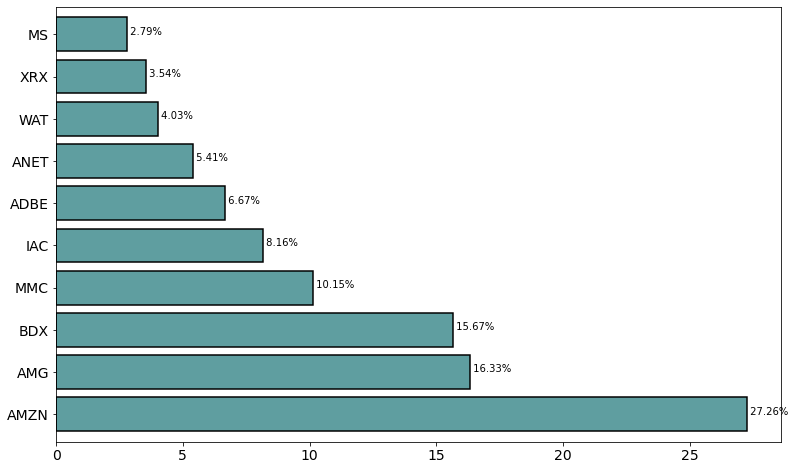

From 2017/01/01 to 2017/12/31:
Return: 53.98%
Risk: 0.0018395457

From 2018/01/01 to 2019/07/31:
Return: 47.95%
Risk: 0.0016322105

When investing $20000 from 2018/01/01 to 2019/07/31:
We will profit $9589.13


In [19]:
optimal_portfolio(stocksdf = stocks, NSTOCKS = 10, iterations = 1000, NSAMP = 1000, money = 20000)

['AIZ', 'AMZN', 'ARNC', 'AVB', 'AVGO', 'BSET', 'CL', 'CR', 'HD', 'IT', 'JNPR', 'LRCX', 'LUV', 'MAA', 'MKC', 'MSFT', 'MTD', 'RL', 'TWTR', 'VAR']

[0.059516021174069914, 0.125185202650455, 0.048318645205137484, 0.035509580322178255, 0.04713828627421585, 0.008071592156546306, 0.06771859562130693, 0.06552424069581565, 0.11884318616618918, 0.08780641484144083, 0.008793745951914093, 0.005559413086096112, 0.0023486664521227595, 0.015937216900568714, 0.034346132519652524, 0.005427428063404831, 0.1114772810108281, 0.102469539992929, 0.02740648753154132, 0.022602323383587312]


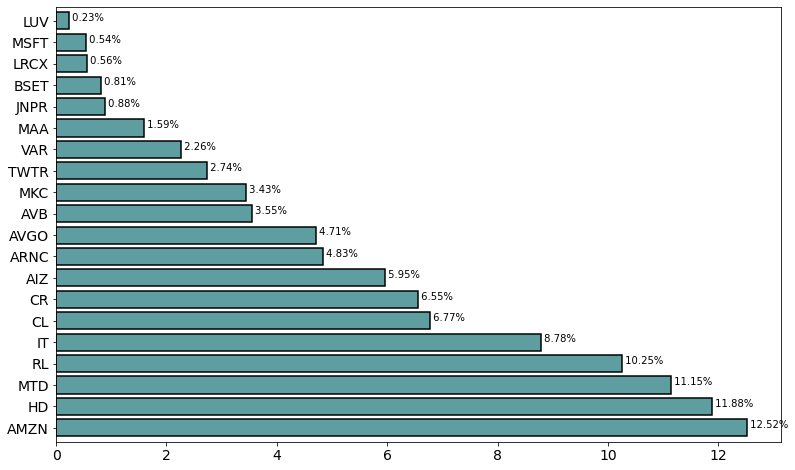

From 2017/01/01 to 2017/12/31:
Return: 44.74%
Risk: 0.0020714619

From 2018/01/01 to 2019/07/31:
Return: 39.33%
Risk: 0.0020218465

When investing $20000 from 2018/01/01 to 2019/07/31:
We will profit $7865.05


In [20]:
optimal_portfolio(stocksdf = stocks, NSTOCKS = 20, iterations = 1000, NSAMP = 1000, money = 20000)

['ADBE', 'ADI', 'ADP', 'AMZN', 'ATI', 'BKNG', 'BLK', 'CBOE', 'CI', 'COP', 'DOV', 'EOG', 'ESS', 'ETR', 'EXPD', 'EXR', 'HRB', 'IR', 'JBHT', 'L', 'LW', 'MET', 'MSI', 'PHM', 'SHW', 'UNH', 'VZ', 'WMT', 'XEL', 'XLNX']

[0.03752809356997221, 0.002055766287511822, 0.04942291246702816, 0.06799200977414457, 0.04490919175084123, 0.0640770277501628, 0.06668965220657677, 0.012640865450781923, 0.05244944117517007, 0.004835908536045357, 0.011444781931468917, 0.013183869465777119, 0.049656610012488535, 0.008988586421969974, 0.028312710572391736, 0.01837923372140519, 0.015755308985754946, 0.04096173266523889, 0.005184025013225718, 0.05704127718603953, 0.004455027261924759, 0.014211005463856482, 0.03065028996318404, 0.04710040194375491, 0.06164114724910249, 0.036990468143119806, 0.020322025503309717, 0.07978286551370108, 0.010886933192053623, 0.04245083082199742]


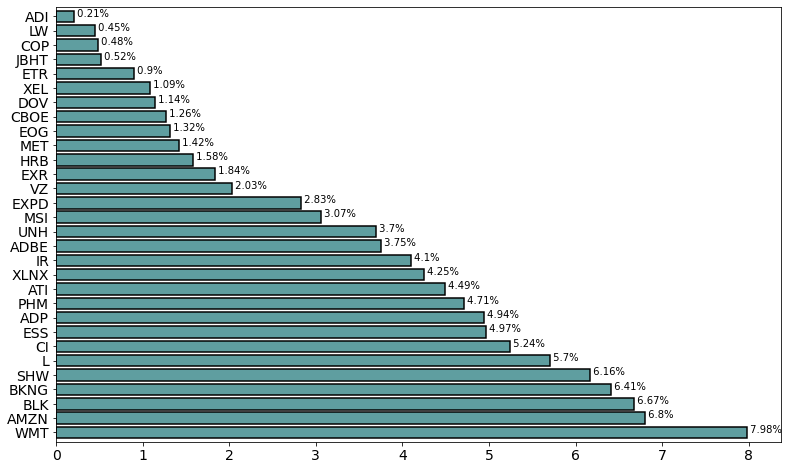

From 2017/01/01 to 2017/12/31:
Return: 33.22%
Risk: 0.0017245524

From 2018/01/01 to 2019/07/31:
Return: 26.1%
Risk: 0.0018171741

When investing $20000 from 2018/01/01 to 2019/07/31:
We will profit $5219.75


In [21]:
optimal_portfolio(stocksdf = stocks, NSTOCKS = 30, iterations = 1000, NSAMP = 1000, money = 20000)